In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim
from gensim import corpora, models, similarities
import os
import utility_synopsis
import math
import numpy as np
from numpy import linalg as la
from scipy.spatial.distance import cosine
import pandas as pd
import matplotlib.pyplot as plt

from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf
import os
import random
import datetime
#from surprise import BaselineOnly
#from surprise import Dataset
#from surprise import evaluate
from surprise import Reader
import collections as coll

import cPickle as pickle

import heapq
import multiprocessing
from itertools import combinations
import pprint

pp = pprint.PrettyPrinter(indent=2, depth=6)

2017-02-26 08:18:27,352 : INFO : 'pattern' package not found; tag filters are not available for English


In [3]:
count_limit = 1000 # only calculate neighbors of a subset of users to avoid space and time problems

def extract_item_info(filename, delimiter, genre_delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            itemId, title, genre_list = map(lambda x: x.strip(), line.split(delimiter))
            
            data[itemId] = (title, genre_list.split(genre_delimiter))
    return data

item_file_name, item_file_delimiter, genre_delimiter = os.path.sep.join(['ml-1m', 'movies.dat']), '::', '|'
item_info = extract_item_info(item_file_name, item_file_delimiter, genre_delimiter)

###
def extract_user_item_interaction(filename, delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            userId, movieId, rating, timestamp = line.split(delimiter)
            #userId = int(userId)
            #movieId = int(movieId)
            rating = float(rating)
            timestamp = int(timestamp)

            if userId not in data:
                data[userId] = []
            data[userId].append((movieId, rating, timestamp))
    
    # order by time
    for userId in data:
        data[userId].sort(key=lambda x: x[2]) 
    return data

rating_file_name, rating_file_delimiter = os.path.sep.join(['ml-1m', 'ratings.dat']), '::'
user_item_interaction = extract_user_item_interaction(rating_file_name, rating_file_delimiter)


In [4]:
all_target_users = []
for i, target_user in enumerate(user_item_interaction):
    if i == count_limit:
        break
    all_target_users.append(target_user)
    

In [5]:
# preparation for word2vec approach

model_path = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model'
model = gensim.models.Word2Vec.load(model_path)

def user_history2user_repr__simple_average(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = map(lambda x: model[x[0]], items_existed_in_model)
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    return np.average(items_translated_to_vecs, axis=0)   

#user_history2user_repr__simple_average(model, user_item_interaction['5989'])
# calculate user representation dict
user_repr__word2vec = {user: user_history2user_repr__simple_average(model, user_item_interaction[user]) for user in user_item_interaction}


2017-02-26 08:18:46,295 : INFO : loading Word2Vec object from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model
2017-02-26 08:18:46,597 : INFO : loading wv recursively from /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model.wv.* with mmap=None
2017-02-26 08:18:46,597 : INFO : setting ignored attribute syn0norm to None
2017-02-26 08:18:46,598 : INFO : setting ignored attribute cum_table to None
2017-02-26 08:18:46,598 : INFO : loaded /home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model


In [10]:
# obsolete

### calculate neighbors of each user
neighbors__word2vec = {}

for i, target_user in enumerate(user_item_interaction):
    if i == count_limit:
        break
        
    target_repr = user_repr__word2vec[target_user]
    #print target_repr
    simi = [(v, target_repr.dot(user_repr__word2vec[v]) / (la.norm(target_repr * la.norm(user_repr__word2vec[v]))))
            for v in user_item_interaction]
    simi.sort(key=lambda x: -1 * x[1])
    
    #print simi[1:K + 1]
    #print simi[-1 * K:]
    neighbors__word2vec[target_user] = simi

In [ ]:
# never executed

with open('chap3_exp2__word2vec__user_repr.dump', 'wb') as fout:
    pickle.dump(user_repr__word2vec, fout)

In [11]:
# This might take a long time

with open('chap3_exp2__word2vec__neighbors.dump', 'wb') as fout:
    pickle.dump(neighbors__word2vec, fout)

KeyboardInterrupt: 

In [79]:
# preparation for simple approach/CF approach


# Calculation implementation has moved to try2.
# We are going to load the calculation result here merely.

#
#def calculate_similar_users__cf(target_user, user_history_dict):
#    simi_list_of_user_u = []
#    interacted_items = [x[0] for x in user_history_dict[target_user]]
#    for v in user_history_dict.keys():
#        if target_user == v:
#            #assert(False)
#            continue
#
#        user_v_history = set([x[0] for x in user_history_dict[v]])
#        #print 'user_v_history:', user_v_history
#        #user_u_repr = np.array(map(lambda x: 1 if x in train[u] else 0, self.distinct_item_list))
#        #user_v_repr = np.array(map(lambda x: 1 if x in train[v] else 0, self.distinct_item_list))
#        #common_items = user_u_history.intersection(user_v_history)
#        item_union = set(interacted_items).union(user_v_history)
#
#        if 0 == len(item_union):
#            simi = 0
#        else:
#            #print_matrix(train[u])
#
#            user_u_repr = np.array(map(lambda x: 1 if x in interacted_items else 0, item_union))
#            user_v_repr = np.array(map(lambda x: 1 if x in user_v_history else 0, item_union))
#
#            #print 'user_u_repr:', user_u_repr
#            #print 'user_v_repr:', user_v_repr
#            simi = user_u_repr.dot(user_v_repr) / (la.norm(user_u_repr * la.norm(user_v_repr)))
#            #raw_input()
#
#            #
#        simi_list_of_user_u.append((v, simi))
#    
#    K_neighbors = heapq.nlargest(!!!!!!!!!!!!!!!!!!!!!!, simi_list_of_user_u, key=lambda s: s[1])    
#    return K_neighbors
#
#calculate_similar_users__cf('5389', user_item_interaction)

[('5338', 0.54522035432037463),
 ('4160', 0.54435314486126218),
 ('602', 0.51948051948051943),
 ('4406', 0.5164277182008723),
 ('1856', 0.5151325112701336),
 ('1215', 0.51097497621000731),
 ('1723', 0.50684691095079826),
 ('1122', 0.50566397768442761),
 ('1598', 0.50495148505436727),
 ('3005', 0.50480318424734094),
 ('3849', 0.50207941319911131),
 ('1135', 0.49769174231796237),
 ('5778', 0.49594975053634627),
 ('2013', 0.49551560448255738),
 ('1206', 0.49539651075124796),
 ('2126', 0.49265895172303803),
 ('3678', 0.49211288450512497),
 ('3874', 0.48843196255368349),
 ('316', 0.47752665742468137),
 ('2466', 0.47508454947893752),
 ('5797', 0.474212590970504),
 ('445', 0.47172817652486326),
 ('17', 0.47153869544936317),
 ('4886', 0.47075134046330769),
 ('2740', 0.46843968307255524),
 ('3123', 0.46602185787265571),
 ('1522', 0.46533156623365501),
 ('5592', 0.46478396416719026),
 ('4272', 0.46241323187365402),
 ('4245', 0.4620706837380904),
 ('5997', 0.45895559366460115),
 ('4219', 0.458911

In [80]:

#class InnerThreadClass(multiprocessing.Process):
#    def __init__(self, name, user_item_interaction, total, partial_test_set):
#        multiprocessing.Process.__init__(self)
#
#        self.name = name
#        self.user_item_interaction = user_item_interaction
#        self.total = total
#        self.partial_test_set = partial_test_set
#        #self.N = N
# 
#    def run(self):
#        rec = {}
#        #print 'self.partial_test_set:', self.partial_test_set
#        for step, user_id in enumerate(self.partial_test_set):
#            #piece_of_test_data = self.partial_test_set[user_id]
#            #history = piece_of_test_data[0]
#            ##print 'history:', history
#            #recommendation = self.recommendator.recommend(history, self.N)
#            ##print 'recommendation: %s' % (str(recommendation))
#            #rec[user_id] = recommendation
#
#            ret = calculate_similar_users__cf(user_id, self.user_item_interaction)
#            rec[user_id] = ret
#            
#            if (0 == step % 64):
#                print 'progress: %d/%d' % (step, self.total)
#                
#
#        #print '[%s]: rec: %s' % (self.name, str(rec))
#        pickle.dump(rec, open(self.name, 'w'))
#        print 'done'

In [81]:
#def calculate_neighbors__cf(all_target_users):
#    threads = []
#    # Start consumers
#    num_threads = multiprocessing.cpu_count() * 2
#    print 'Creating %d threads' % num_threads
#    piece_len = len(all_target_users) / num_threads
#
#    pieces = []
#    user_id_list = list(all_target_users)
#    pieces = [user_id_list[x * piece_len: (x + 1) * piece_len] for x in xrange(0, num_threads + 1)]
#
#
#    # 创建线程对象
#    name_prefix = 'chap3_exp2_thread-'
#    name_postfix = '.dump'
#    for en, x in enumerate(pieces):
#        name = name_prefix + str(en) + name_postfix
#        threads.append(InnerThreadClass(name, user_item_interaction, len(user_id_list), x))
#    for t in threads:
#        t.start()
#    for t in threads:
#        t.join()  
#
#    total = len(user_id_list)
#    print 'progress: %d/%d. done.' % (total, total)
#    
#    W_pieces = [pickle.load(open(name, 'r')) for name in [name_prefix + str(en) + name_postfix for en, x in enumerate(pieces)]]
#    W = {}
#    map(lambda x: W.update(x), W_pieces)
#    
#    return W
#
#
#
#starttime = datetime.datetime.now()
#
#calculate_neighbors__cf(all_target_users)
#
#endtime = datetime.datetime.now()
#interval = (endtime - starttime).seconds
#print 'metric calculation: time consumption: %d' % (interval)

Creating 8 threads
done
progress: 0/1000
progress: 0/1000
progress: 0/1000
progress: 0/1000
progress: 0/1000
progress: 0/1000
progress: 0/1000
progress: 0/1000
progress: 64/1000
progress: 64/1000
progress: 64/1000
progress: 64/1000
progress: 64/1000
progress: 64/1000
progress: 64/1000
done
progress: 64/1000
done
done
done
done
done
done
done
progress: 1000/1000. done.
metric calculation: time consumption: 1136


In [6]:
# load calculation result for simple/CF approach

name_prefix = 'chap3_exp2_thread-'
name_postfix = '.dump'

simi__simple__whole = None
with open(name_prefix + 'final_dump' + name_postfix, 'r') as f:
    simi__simple__whole = pickle.load(f)

In [3]:
simi__simple__whole.keys()[:10]

['4726', '5590', '2305', '4049', '799', '4789', '4788', '4787', '4786', '4785']

In [4]:
simi__simple__whole['4726']

[('854', 0.44131429467020544),
 ('1050', 0.4355283987196143),
 ('5657', 0.41399992533862912),
 ('4141', 0.41123105315627767),
 ('1962', 0.4093928957723591),
 ('1203', 0.40180515221021634),
 ('187', 0.40171480816135985),
 ('1139', 0.39656428415602235),
 ('3328', 0.39574746704954206),
 ('5428', 0.3953322234999978),
 ('3205', 0.39483428015761296),
 ('5306', 0.39313761219071824),
 ('5718', 0.38509744495372661),
 ('4611', 0.38320185731731177),
 ('4659', 0.38289485072045309),
 ('3017', 0.38116439651571948),
 ('4430', 0.38070489369946664),
 ('331', 0.37880968977039525),
 ('4139', 0.37757235210854906),
 ('1724', 0.37713618804862076),
 ('3067', 0.3764333967304751),
 ('897', 0.37549250500682163),
 ('1354', 0.37048133742910444),
 ('899', 0.37044483484484964),
 ('3125', 0.36965025742001667),
 ('5333', 0.36940120426516659),
 ('5759', 0.36657028393795449),
 ('5881', 0.36590217520160218),
 ('4786', 0.36421669491070935),
 ('5812', 0.36402578118637396),
 ('1164', 0.36386923598866805),
 ('1980', 0.36339

In [7]:
# preparation for content-based approach
# preparation for calculation of nearest neighbors of a target in content-based approach
genres = ["Action",
"Adventure",
"Animation",
"Children's",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western",]

genres_index_dict = dict(zip(*[genres, range(len(genres))]))
index_genres_dict = dict(zip(*[range(len(genres)), genres]))

def extract_genres(filename, delimiter, genre_delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            itemId, title, genre_list = map(lambda x: x.strip(), line.split(delimiter))
            
            data[itemId] = genre_list.split(genre_delimiter)
    return data

item_file_name, item_file_delimiter, genre_delimiter = os.path.sep.join(['ml-1m', 'movies.dat']), '::', '|'
item_info = extract_genres(item_file_name, item_file_delimiter, genre_delimiter)

def tmp_set(vec, i, val):
    vec[i] = val
    
def generate_item_repr(item_info):
    item_repr = {}
    for item in item_info:
        #print item
        f = np.array([0] * len(genres))
        map(lambda x: tmp_set(f, genres_index_dict[x], 1), item_info[item])
        #print f
        item_repr[item] = f
        #break
    return item_repr

cb_item_repr = generate_item_repr(item_info)

###
def user_history2user_repr__simple_average(cb_item_repr, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    items_translated_to_vecs = map(lambda x: cb_item_repr[x[0]], target_user_history)
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    return np.average(items_translated_to_vecs, axis=0)   

# calculate user representation dict
user_repr__cb = {user: user_history2user_repr__simple_average(cb_item_repr, user_item_interaction[user]) for user in user_item_interaction}


In [52]:
user_repr__cb['5389']

array([ 0.42857143,  0.19480519,  0.01298701,  0.03246753,  0.22077922,
        0.03246753,  0.        ,  0.18181818,  0.05194805,  0.01948052,
        0.15584416,  0.00649351,  0.02597403,  0.04545455,  0.68181818,
        0.23376623,  0.05844156,  0.01948052])

In [8]:
# preparation for svd approach
data_filename, delimiter, data_set = os.path.sep.join(['ml-1m', 'ratings.dat']), '::', '1M'

chap3_exp2__svd_dump = 'chap3_exp2__tmp__svd_dump.algo'
chap3_exp2_train_file_name = 'chap3_exp2__tmp__svd_train'
chap3_exp2_test_file_name = 'chap3_exp2__tmp__svd_test'
my_sep = ':'

if not os.path.exists(chap3_exp2__svd_dump):
    with open(chap3_exp2_test_file_name, 'w') as f: # Yes, emtpy test file. We are going to use full dataset.
        pass
    with open(chap3_exp2_train_file_name, 'w') as fout: # Write full dataset into train file.
        with open(data_filename, 'r') as f:
            for i, line in enumerate(f):
                fout.write(my_sep.join(line.split(delimiter)))
#

##
reader = Reader(line_format='user item rating timestamp', sep=my_sep)

data = Dataset.load_from_folds([(chap3_exp2_train_file_name, chap3_exp2_test_file_name)], reader=reader)

for trainset, testset in data.folds():
    first_train, first_test = trainset, testset
    
print 'info of train:'
print first_train.n_users
print first_train.n_items
print first_train.n_ratings

print 'info of test:'
print len(first_test)


##
algo = None
if os.path.exists(chap3_exp2__svd_dump):
    print '[Note]: SVD dump exists already. Going to load it!'
    with open(chap3_exp2__svd_dump, 'rb') as f:
        algo = pickle.load(f)
else:    
    print '[Note]: SVD dump does not exist. Going to train a SVD!'
    # train SVD
    starttime = datetime.datetime.now()

    algo = SVD()
    algo.train(first_train)

    ###
    endtime = datetime.datetime.now()
    interval = (endtime - starttime).seconds
    print 'svd time consumption: %d' % (interval)
    
    with open(chap3_exp2__svd_dump, 'wb') as f:
        pickle.dump(algo, f)


##
#all_user_ids_in_svd_train = set()
#with open(train_file_name, 'r') as fin:
#    for i, line in enumerate(fin):
#        userId, movieId, rating, timestamp = line.split(my_sep)
#        all_user_ids_in_svd_train.add(userId)
##


info of train:
6040
3706
1000209
info of test:
0
[Note]: SVD dump exists already. Going to load it!


In [10]:

##
def generate_svd_user_repr(user_item_interaction):
    '''Constraint for @para: There should be some method to extract all user ids from the @para.'''
    user_repr = {}
    svd_missing_count = 0
    for user in user_item_interaction:
        
        try:
            inner_uid = first_train.to_inner_uid(user)
            user_repr[user] = algo.pu[inner_uid]
        except ValueError, e:
            svd_missing_count += 1
    print 'svd_missing_count:', svd_missing_count
    return user_repr

svd_user_repr = generate_svd_user_repr(user_item_interaction)


#### calculate neighbors of each user
#neighbors__svd = {}
#
#for i, target_user in enumerate(user_item_interaction):
#    if i == count_limit:
#        break
#        
#    target_repr = svd_user_repr[target_user]
#    #print target_repr
#    simi = [(v, target_repr.dot(svd_user_repr[v]) / (la.norm(target_repr * la.norm(svd_user_repr[v]))))
#            for v in user_item_interaction]
#    simi.sort(key=lambda x: -1 * x[1])
#    
#    #print simi[1:K + 1]
#    #print simi[-1 * K:]
#    neighbors__svd[target_user] = simi

svd_missing_count: 0


In [30]:
all_target_users[1]

'5989'

In [35]:
svd_user_repr['5988']

array([ 0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07320169,
        0.07320169,  0.07320169,  0.07320169,  0.07320169,  0.07

In [34]:
svd_user_repr['5989']

array([ 0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04600196,
        0.04600196,  0.04600196,  0.04600196,  0.04600196,  0.04

In [32]:
svd_user_repr['5989'].dot(svd_user_repr['5988']) / (la.norm(svd_user_repr['5989'] * la.norm(svd_user_repr['5988'])))

1.0

In [26]:
algo.pu[1]

array([ 0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02720527,
        0.02720527,  0.02720527,  0.02720527,  0.02720527,  0.02

In [27]:
algo.pu[2]

array([ 0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04645943,
        0.04645943,  0.04645943,  0.04645943,  0.04645943,  0.04

In [28]:
algo.pu[3]

array([ 0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10212395,
        0.10212395,  0.10212395,  0.10212395,  0.10212395,  0.10

In [11]:
def my_cosine_similarity_with_regression(target, b):
    '''ATTENTION: This function might have problem regarding to scale: While value of cosine similarity 
    ranges from 0(included) to 1(included), the Euclidean distance might not so.'''
    cos = target.dot(b) / (la.norm(target * la.norm(b)))
    if cos > 0.99999 or cos < -0.99999:
        # Euclidean distance
        return -1 * abs(target[0] - b[0])  # for consistency: bigger means more similar
    else:
        return cos # bigger means more similar


In [12]:
mn_simple = 'simple'
mn_cb = 'cb'
mn_svd = 'svd'
mn_word2vec = 'word2vec'

mn_list = [mn_simple, mn_cb, mn_svd, mn_word2vec]

In [1]:
# For user, analyze any two neighborhood calculated by simple approach, content-based approach, 
# word2vec approach and svd approach.


def find_out_intersection_size_sum_with_given_limit_list__x(limit_list, all_target_users):
    global mn_simple, mn_cb, mn_svd, mn_word2vec, mn_list
    
    for limit in limit_list:
        assert(limit < 512) # In simple/CF approach, only 512 neighbors of target user is calculated.
    
    ##
    intersection_size_map = coll.defaultdict(lambda:coll.defaultdict(list))
    union_size_map = coll.defaultdict(lambda:coll.defaultdict(list))

    missing_count__cb = 0
    missing_count__svd = 0

    i = None
    for __step, target_user in enumerate(all_target_users):
        #print item_id
        if 0 == __step % 100:
            print 'progress: %d/%d' % (__step, len(all_target_users))

        # simple/CF <START>
        sims_simple = simi__simple__whole[target_user]
        neighbors__simple = sims_simple
        # simple/CF <END>
            
        # content-based <START>
        #cb_target_repr = item_repr[item_id] # cb: content based
        #sims_cb = [(iid, cb_target_repr.dot(item_repr[iid]) / 
        #            (la.norm(cb_target_repr * la.norm(item_repr[iid])))) for iid in model.wv.vocab]
        ##print sims[0]
        #sims_cb = sorted(sims_cb, key=lambda item: -1 * item[1])
        target_repr__cb = user_repr__cb[target_user]
        simi__cb = [(v, target_repr__cb.dot(user_repr__cb[v]) 
                 / (la.norm(target_repr__cb * la.norm(user_repr__cb[v]))))
                for v in user_item_interaction]
        simi__cb.sort(key=lambda x: -1 * x[1])
        neighbors__cb = simi__cb
        # content-based <END>
       
    
        # svd <START>
        #        svd_target_repr = svd_item_repr[item_id]
        #        #print 'svd_target_repr:', svd_target_repr
        #        sims_svd = [(iid, svd_target_repr.dot(svd_item_repr[iid]) / 
        #                     (la.norm(svd_target_repr * la.norm(svd_item_repr[iid])))) for iid in all_item_ids_in_svd_train]
        #        sims_svd = sorted(sims_svd, key=lambda item: -1 * item[1])
        #        #print 'sims_svd:', sims_svd
                
        target_repr__svd = svd_user_repr[target_user]
        simi__svd = [(v, my_cosine_similarity_with_regression(target_repr__svd, svd_user_repr[v]))
                for v in user_item_interaction]
        simi__svd.sort(key=lambda x: -1 * x[1])
        neighbors__svd = simi__svd
        ##
        # svd <END>

        # word2vec <START>
        #        ret_by_word2vec = model.most_similar(str(item_id), topn=max(limit_list))
        
        target_repr__word2vec = user_repr__word2vec[target_user]
        simi__word2vec = [(v, target_repr__word2vec.dot(user_repr__word2vec[v]) 
                 / (la.norm(target_repr__word2vec * la.norm(user_repr__word2vec[v]))))
                for v in user_item_interaction]
        simi__word2vec.sort(key=lambda x: -1 * x[1])
        neighbors__word2vec = simi__word2vec
        # word2vec <END>
        
        ## testing
        ##print 'neighbors__svd:', neighbors__svd[:10], '...', neighbors__svd[-10:]
        ##print 'neighbors__word2vec:', neighbors__word2vec[:10], '...', neighbors__word2vec[-10:]
        ##
        ##tmp__limit = 800
        ##tmp__svd = [x[0] for x in neighbors__svd[:tmp__limit]]
        ##tmp__word2vec = [x[0] for x in neighbors__word2vec[:tmp__limit]]
        ##print len(set(tmp__svd).intersection(tmp__word2vec))
        ##print len(set(tmp__svd).union(tmp__word2vec))
        ##
        ##print
        ##print
        ####
        ##print 'neighbors__cb:', neighbors__cb[:10], '...', neighbors__cb[-10:]
        ##print 'neighbors__word2vec:', neighbors__word2vec[:10], '...', neighbors__word2vec[-10:]
        ##
        ##tmp__limit = 400
        ##tmp__cb = [x[0] for x in neighbors__cb[:tmp__limit]]
        ##tmp__word2vec = [x[0] for x in neighbors__word2vec[:tmp__limit]]
        ##print len(set(tmp__cb).intersection(tmp__word2vec))
        ##print len(set(tmp__cb).union(tmp__word2vec))
        ##break
        
        ###
        
        for limit in limit_list:
            most_similar_by_simple = [x[0] for x in neighbors__simple[:limit]]  # Careful! The index range!
            #print(sims[1:limit+1])
            most_similar_by_cb = [x[0] for x in neighbors__cb[1:limit+1]]  # Careful! The index range!
            #print most_similar_by_cb

            most_similar_by_svd = [x[0] for x in neighbors__svd[1:limit+1]]  # Careful! The index range!
            
            most_similar_by_word2vec = [x[0] for x in neighbors__word2vec][:limit]  # Careful! The index range! Most similar items by word2vec don't include target item itself.
            #print most_similar_by_word2vec

            
            ###
            most_similar_dict = {}
            most_similar_dict[mn_simple] = most_similar_by_simple
            most_similar_dict[mn_cb] = most_similar_by_cb
            most_similar_dict[mn_svd] = most_similar_by_svd
            most_similar_dict[mn_word2vec] = most_similar_by_word2vec
            for (com_A, com_B) in combinations(mn_list, 2):
                most_similar_dict_A = most_similar_dict[com_A]
                most_similar_dict_B = most_similar_dict[com_B]
                
                inter = set(most_similar_dict_A).intersection(set(most_similar_dict_B))
                intersection_size_map[limit][com_A + '__' + com_B].append(len(inter))
                union = set(most_similar_dict_A).union(set(most_similar_dict_B))
                union_size_map[limit][com_A + '__' + com_B].append(len(union))
            
            ##print 'cb:', most_similar_by_cb
            ##print 'word2vec:', most_similar_by_word2vec
            ##print 'svd:', most_similar_by_svd
            #
            ##print set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            #inter = set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            #intersection_size_map[limit]['cb__word2vec'].append(len(inter))
            #union = set(most_similar_by_cb).union(set(most_similar_by_word2vec))
            #union_size_map[limit]['cb__word2vec'].append(len(union))
            #
            ##
            #inter = set(most_similar_by_cb).intersection(set(most_similar_by_svd))
            ##                              (len(set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))))
            #intersection_size_map[limit]['cb__svd'].append(len(inter))
            #union = set(most_similar_by_cb).union(set(most_similar_by_svd))
            #union_size_map[limit]['cb__svd'].append(len(union))
            #
            #inter = set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))
            #intersection_size_map[limit]['word2vec__svd'].append(len(inter))
            #union = set(most_similar_by_word2vec).union(set(most_similar_by_svd))
            #union_size_map[limit]['word2vec__svd'].append(len(union))
                          
            #break
        #if 0 < len(inter):
        #    print item_id
        #if 0 == __step:
        #    break

    print 'missing_count__cb:', missing_count__cb
    print 'missing_count__svd:', missing_count__svd

    return intersection_size_map, union_size_map


r = find_out_intersection_size_sum_with_given_limit_list__x([400], all_target_users)
#r = find_out_intersection_size_sum_with_given_limit_list__x(range(10, 500, 10))
#pp.pprint(r)
#for k in r:
#    print k

In [40]:
limit_list = range(10, 500, 10)
r__across_methods = find_out_intersection_size_sum_with_given_limit_list__x(limit_list, all_target_users)

progress: 0/1000
progress: 100/1000
progress: 200/1000
progress: 300/1000
progress: 400/1000
progress: 500/1000
progress: 600/1000
progress: 700/1000
progress: 800/1000
progress: 900/1000
missing_count__cb: 0
missing_count__svd: 0


In [15]:
r__across_methods

KeyboardInterrupt: 

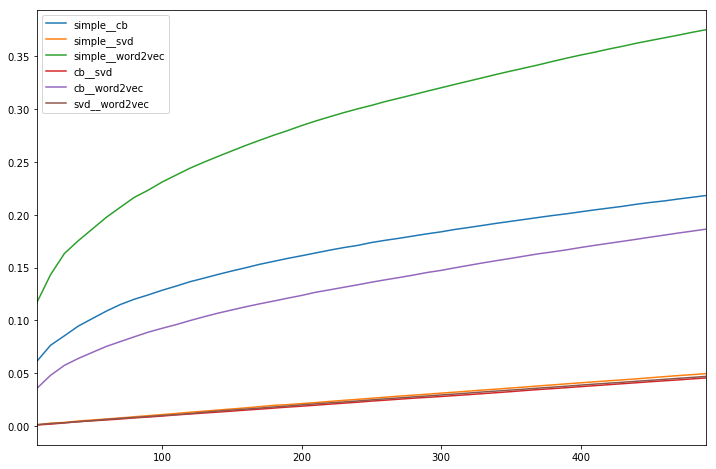

In [60]:
def draw_jaccard(inter_uni_tupple, method_or_variant_name_list):
    k = None
    inter, uni = inter_uni_tupple
    jaccard = {}
    for limit in inter:
        jaccard[limit] = {}
        for comb_of_2_methods in inter[limit]:
            jaccard[limit][comb_of_2_methods] = np.average(np.array(inter[limit][comb_of_2_methods]) * 1. / 
                                                           np.array(uni[limit][comb_of_2_methods]))

    ##
    # This weird variable name is intended to suggest that the level 1 key of this varibale 
    # is combination of any two methods
    jaccard_lev1_key_comb___coll = {}

    for com_A, com_B in combinations(method_or_variant_name_list, 2):
        jaccard_lev1_key_comb___coll[com_A + '__' + com_B] = []

    for limit in sorted(jaccard.keys()):    # from smaller limit to larger limit, in consistency with the x-axis...
        for com_A, com_B in combinations(method_or_variant_name_list, 2):
            comb = com_A + '__' + com_B
            jaccard_lev1_key_comb___coll[comb].append(jaccard[limit][comb])

    #cb__word2vec__coll = {}
    #cb__svd__coll = {}
    #word2vec__svd__coll = {}
    #for k in jaccard:
    #    print k, ', '.join([': '.join([sub_k, str(jaccard[k][sub_k])]) for sub_k in jaccard[k]])
    #    
    #    cb__word2vec__coll[k] = jaccard[k]['cb__word2vec']
    #    cb__svd__coll[k] = jaccard[k]['cb__svd']
    #    word2vec__svd__coll[k] = jaccard[k]['word2vec__svd']
    #    
    ####
    #cb__word2vec__coll = sorted(cb__word2vec__coll.items(), key=lambda x: x[0])
    #cb__svd__coll = sorted(cb__svd__coll.items(), key=lambda x: x[0])
    #word2vec__svd__coll = sorted(word2vec__svd__coll.items(), key=lambda x: x[0])
    #print cb__word2vec__coll
    #print cb__svd__coll
    #print word2vec__svd__coll

    ###
    indexes = limit_list
    values = []
    for com_A, com_B in combinations(method_or_variant_name_list, 2):
        comb = com_A + '__' + com_B
        values.append(jaccard_lev1_key_comb___coll[comb][:])

    values = zip(*values)
    #values__cb__word2vec = [x[1] for x in cb__word2vec__coll]
    #values__cb__svd = [x[1] for x in cb__svd__coll]
    #values__word2vec__svd = [x[1] for x in word2vec__svd__coll]
    #values = zip(*[values__cb__word2vec, values__cb__svd, values__word2vec__svd])
    #df = pd.DataFrame(values, index=indexes, columns=['cb__word2vec', 'cb__svd', 'word2vec__svd'])
    df = pd.DataFrame(values, 
                      index=indexes, 
                      columns=[com_A + '__' + com_B for com_A, com_B in combinations(method_or_variant_name_list, 2)])

    df.plot()

    fig = plt.gcf()
    fig.set_size_inches(12, 8, forward=True)
    plt.show()
    
    return jaccard_lev1_key_comb___coll
    

tmp_r = draw_jaccard(r__across_methods, mn_list)

In [18]:
jaccard_lev1_key_comb___coll['cb__svd'][:10]

[0.0010526315789473684,
 0.0018771929824561405,
 0.00298947983635301,
 0.0042114627988045711,
 0.004979385442004618,
 0.0057958629400507505,
 0.0066930628846449368,
 0.0077424761711401974,
 0.0085576991065770564,
 0.0094826105100733731]

In [53]:
jaccard_lev1_key_comb___coll['simple__svd'][:10]

[0.001,
 0.0027773279352226719,
 0.0034548300910077646,
 0.0047776252173320792,
 0.0057517477987800679,
 0.0067216274707062743,
 0.0076875763923364218,
 0.0088497200701157935,
 0.0098643335624461707,
 0.010883954952136305]

In [54]:
jaccard_lev1_key_comb___coll['svd__word2vec'][:10]

[0.0013684210526315787,
 0.0023400809716599188,
 0.0032016672306130613,
 0.0040981086424124397,
 0.0051969617275213738,
 0.0063346773018416822,
 0.0073251310664831908,
 0.0081260928172495524,
 0.0090523440322860006,
 0.00999845115362402]

In [ ]:
'''chap 3 exp 2 coefficient - inside word2vec - across multiple representations'''

In [33]:
def user_history2user_repr__rating(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = np.array(map(lambda x: model[x[0]], items_existed_in_model))
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    
    w = np.array([x[1] for x in items_existed_in_model]) * 1.
    
    return w.dot(items_translated_to_vecs) / np.sum(w)


def user_history2user_repr__simple_time(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    time_coef = 0.9
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = np.array(map(lambda x: model[x[0]], items_existed_in_model))
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    
    #return reduce(lambda x, y: 0.9 * x + 0.1 * y, items_translated_to_vecs)

    w = time_coef ** np.array(range(len(items_translated_to_vecs) - 1, 0 - 1, -1)) * 1.
    
    return w.dot(items_translated_to_vecs) / np.sum(w)

def user_history2user_repr__rating_time(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    time_coef = 0.9
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'num of filtered items:', len(target_user_history) - len(items_existed_in_model)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = np.array(map(lambda x: model[x[0]], items_existed_in_model))
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    
    #return reduce(lambda x, y: 0.9 * x + 0.1 * y, items_translated_to_vecs)
    # Careful! We should use items_existed_in_model rather than target_user_history!!!
    w = time_coef ** np.array(range(len(items_translated_to_vecs) - 1, 0 - 1, -1)) * np.array([x[1] for x in items_existed_in_model]) * 1.
    
    return w.dot(items_translated_to_vecs) / np.sum(w)

In [20]:
### calculate neighbors of each user
def calculate_user_representation_in_word2vec_variant(func):
    # calculate user representation dict
    user_repr__word2vec_variant = {user: func(model, user_item_interaction[user]) for user in user_item_interaction}
    return user_repr__word2vec_variant


In [21]:
# item tf-idf

df = coll.defaultdict(int)
for user in user_item_interaction:
    distinct_items = set([x[0] for x in user_item_interaction[user]])
    for item in distinct_items:
        df[item] += 1
num_of_users = len(user_item_interaction.keys())

idf = {item: math.log(num_of_users * 1. / df[item]) for item in df}


In [107]:
df
# df['1200'] should equal to 1820 <== verified in ratings.data

defaultdict(int,
            {'1200': 1820,
             '3724': 195,
             '3725': 112,
             '592': 1431,
             '344': 766,
             '345': 469,
             '346': 120,
             '347': 46,
             '340': 84,
             '341': 31,
             '342': 518,
             '343': 42,
             '2918': 1473,
             '348': 455,
             '349': 1059,
             '1296': 560,
             '594': 763,
             '2318': 320,
             '2316': 236,
             '2317': 8,
             '2314': 104,
             '2315': 147,
             '2312': 331,
             '2313': 457,
             '2310': 134,
             '2311': 470,
             '298': 23,
             '299': 143,
             '296': 2171,
             '297': 28,
             '294': 42,
             '295': 29,
             '292': 733,
             '293': 923,
             '290': 168,
             '291': 48,
             '3773': 171,
             '3772': 3,
             '3771': 151,

In [74]:
tfidf = idf

In [78]:

def user_history2user_repr__simple__tfidf(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = np.array(map(lambda x: model[x[0]], items_existed_in_model))
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    w = np.array([tfidf[x[0]] for x in items_existed_in_model]) * 1.
    
    return w.dot(items_translated_to_vecs) / np.sum(w)   


def user_history2user_repr__rating__tfidf(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = np.array(map(lambda x: (model[x[0]]), items_existed_in_model))
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    
    w = np.array([tfidf[x[0]] for x in items_existed_in_model]) * 1. * np.array([x[1] for x in items_existed_in_model])
    
    return w.dot(items_translated_to_vecs) / np.sum(w)


def user_history2user_repr__simple__time__tfidf(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    time_coef = 0.9
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = np.array(map(lambda x: model[x[0]], items_existed_in_model))
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    
    #return reduce(lambda x, y: 0.9 * x + 0.1 * y, items_translated_to_vecs)

    w = time_coef ** np.array(range(len(items_translated_to_vecs) - 1, 0 - 1, -1)) * 1. * np.array([tfidf[x[0]] for x in items_existed_in_model])
    
    return w.dot(items_translated_to_vecs) / np.sum(w)

def user_history2user_repr__rating__time__tfidf(model, target_user_history): # target_user_history: It should_be_a_list_of_tuples_included_items.
    time_coef = 0.9
    #print 'target_user_history:', target_user_history
    items_existed_in_model = filter(lambda x: x[0] in model, target_user_history)
    #print 'num of filtered items:', len(target_user_history) - len(items_existed_in_model)
    #print 'items_existed_in_model:', items_existed_in_model[0]
    items_translated_to_vecs = np.array(map(lambda x: model[x[0]], items_existed_in_model))
    #print 'items_translated_to_vecs:', items_translated_to_vecs[0]
    
    #return reduce(lambda x, y: 0.9 * x + 0.1 * y, items_translated_to_vecs)
    # Careful! We should use items_existed_in_model rather than target_user_history!!!
    w = time_coef ** np.array(range(len(items_translated_to_vecs) - 1, 0 - 1, -1)) * np.array([x[1] for x in items_existed_in_model]) * 1. * np.array([tfidf[x[0]] for x in items_existed_in_model])
    
    return w.dot(items_translated_to_vecs) / np.sum(w)

In [27]:
# For user, analyze any two neighborhood calculated by vairants of word2vec approach.



user_repr__word2vec__simple = user_repr__word2vec


In [34]:
user_repr__word2vec__rating = calculate_user_representation_in_word2vec_variant(user_history2user_repr__rating)

In [29]:
user_repr__word2vec__simple_time = calculate_user_representation_in_word2vec_variant(user_history2user_repr__simple_time)

user_repr__word2vec__rating_time = calculate_user_representation_in_word2vec_variant(
    user_history2user_repr__rating_time)

In [72]:
dir()

['Dataset',
 'In',
 'Out',
 'Reader',
 'SVD',
 '_',
 '_18',
 '_59',
 '_63',
 '_64',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__name__',
 '__package__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i46',
 '_i47',
 '_i48',
 '_i49',
 '_i5',
 '_i50',
 '_i51',
 '_i52',
 '_i53',
 '_i54',
 '_i55',
 '_i56',
 '_i57',
 '_i58',
 '_i59',
 '_i6',
 '_i60',
 '_i61',
 '_i62',
 '_i63',
 '_i64',
 '_i65',
 '_i66',
 '_i67',
 '_i68',
 '_i69',
 '_i7',
 '_i70',
 '_i71',
 '_i72',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_sh',
 'algo',
 'all_target_users',
 'calculate_user_representation_in_word2vec_variant',
 'cb_item_repr',
 'chap3_exp2__svd_dump',
 'chap

In [70]:
vr_simple = 'simple'
vr_rating = 'rating'
vr_simple_time = 'simple_time'
vr_rating_time = 'rating_time'

vr_list__part_1 = [vr_simple, vr_rating, vr_simple_time, vr_rating_time]

user_repr__word2vec__dict__part_1 = {
    vr_simple: user_repr__word2vec__simple,
    vr_rating: user_repr__word2vec__rating,
    vr_simple_time: user_repr__word2vec__simple_time,
    vr_rating_time: user_repr__word2vec__rating_time,
}
vr_list = None
user_repr__word2vec__dict = None

In [47]:

def find_out_intersection_size_sum_with_given_limit_list__x__across_variants(limit_list, 
                                                                             all_target_users, 
                                                                             user_repr__word2vec__dict, 
                                                                             vr_list):
    
    ## method names
    
    ##
    intersection_size_map = coll.defaultdict(lambda:coll.defaultdict(list))
    union_size_map = coll.defaultdict(lambda:coll.defaultdict(list))

    missing_count__cb = 0
    missing_count__svd = 0

    i = None
    for __step, target_user in enumerate(all_target_users):
        #print item_id
        if 0 == __step % 100:
            print 'progress: %d/%d' % (__step, len(all_target_users))

        ###
        neighbors__word2vec__dict = {}
        for variant in vr_list:
            #print 'current variant:', variant
            user_repr_by_variant = user_repr__word2vec__dict[variant]
            
            target_repr__word2vec = user_repr_by_variant[target_user]
            simi__word2vec = [(v, target_repr__word2vec.dot(user_repr_by_variant[v]) 
                     / (la.norm(target_repr__word2vec * la.norm(user_repr_by_variant[v]))))
                    for v in user_item_interaction]
            simi__word2vec.sort(key=lambda x: -1 * x[1])
            neighbors__word2vec__dict[variant] = simi__word2vec
        
        
        ## testing
        ##print 'neighbors__svd:', neighbors__svd[:10], '...', neighbors__svd[-10:]
        ##print 'neighbors__word2vec:', neighbors__word2vec[:10], '...', neighbors__word2vec[-10:]
        ##
        ##tmp__limit = 800
        ##tmp__svd = [x[0] for x in neighbors__svd[:tmp__limit]]
        ##tmp__word2vec = [x[0] for x in neighbors__word2vec[:tmp__limit]]
        ##print len(set(tmp__svd).intersection(tmp__word2vec))
        ##print len(set(tmp__svd).union(tmp__word2vec))
        ##
        ##print
        ##print
        ####
        ##print 'neighbors__cb:', neighbors__cb[:10], '...', neighbors__cb[-10:]
        ##print 'neighbors__word2vec:', neighbors__word2vec[:10], '...', neighbors__word2vec[-10:]
        ##
        ##tmp__limit = 400
        ##tmp__cb = [x[0] for x in neighbors__cb[:tmp__limit]]
        ##tmp__word2vec = [x[0] for x in neighbors__word2vec[:tmp__limit]]
        ##print len(set(tmp__cb).intersection(tmp__word2vec))
        ##print len(set(tmp__cb).union(tmp__word2vec))
        ##break
        
        ###
        
        for limit in limit_list:
            ###
            # Careful! The index range! Most similar items by word2vec don't include target item itself.
            most_similar_dict = {variant: [x[0] for x in neighbors__word2vec__dict[variant]][:limit] for variant in vr_list}
            
            for (com_A, com_B) in combinations(vr_list, 2):
                most_similar_dict_A = most_similar_dict[com_A]
                most_similar_dict_B = most_similar_dict[com_B]
                
                inter = set(most_similar_dict_A).intersection(set(most_similar_dict_B))
                intersection_size_map[limit][com_A + '__' + com_B].append(len(inter))
                union = set(most_similar_dict_A).union(set(most_similar_dict_B))
                union_size_map[limit][com_A + '__' + com_B].append(len(union))
            
            ##print 'cb:', most_similar_by_cb
            ##print 'word2vec:', most_similar_by_word2vec
            ##print 'svd:', most_similar_by_svd
            #
            ##print set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            #inter = set(most_similar_by_cb).intersection(set(most_similar_by_word2vec))
            #intersection_size_map[limit]['cb__word2vec'].append(len(inter))
            #union = set(most_similar_by_cb).union(set(most_similar_by_word2vec))
            #union_size_map[limit]['cb__word2vec'].append(len(union))
            #
            ##
            #inter = set(most_similar_by_cb).intersection(set(most_similar_by_svd))
            ##                              (len(set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))))
            #intersection_size_map[limit]['cb__svd'].append(len(inter))
            #union = set(most_similar_by_cb).union(set(most_similar_by_svd))
            #union_size_map[limit]['cb__svd'].append(len(union))
            #
            #inter = set(most_similar_by_word2vec).intersection(set(most_similar_by_svd))
            #intersection_size_map[limit]['word2vec__svd'].append(len(inter))
            #union = set(most_similar_by_word2vec).union(set(most_similar_by_svd))
            #union_size_map[limit]['word2vec__svd'].append(len(union))
                          
            #break
        #if 0 < len(inter):
        #    print item_id
        #if 0 == __step:
        #    break

    print 'missing_count__cb:', missing_count__cb
    print 'missing_count__svd:', missing_count__svd

    return intersection_size_map, union_size_map


r_across_variants__part_1 = find_out_intersection_size_sum_with_given_limit_list__x__across_variants([400], 
                                                                             all_target_users, 
                                                                             user_repr__word2vec__dict, 
                                                                             vr_list)

#pp.pprint(r)
#for k in r_across_variants__part_1:
#    print k

progress: 0/1000
progress: 100/1000


KeyboardInterrupt: 

In [92]:
limit_list = range(10, 500, 10)
r_across_variants__part_1 = find_out_intersection_size_sum_with_given_limit_list__x__across_variants(limit_list,
                                                                                             all_target_users, 
                                                                                             user_repr__word2vec__dict__part_1, 
                                                                                             vr_list__part_1)

progress: 0/1000
progress: 100/1000
progress: 200/1000
progress: 300/1000
progress: 400/1000
progress: 500/1000
progress: 600/1000
progress: 700/1000
progress: 800/1000
progress: 900/1000
missing_count__cb: 0
missing_count__svd: 0


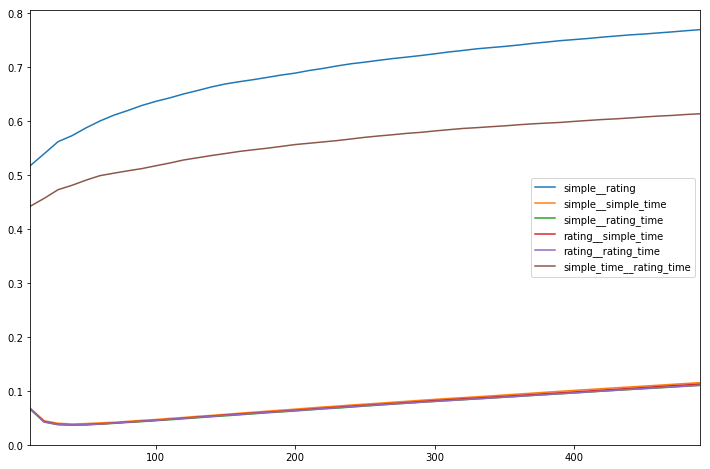

In [61]:
jaccard_part_1 = draw_jaccard(r_across_variants__part_1, vr_list)

In [66]:
print jaccard_part_1['rating__rating_time'][(400 - 10) / 10]
print jaccard_part_1['simple_time__rating_time'][(400 - 10) / 10]

0.0965155846184
0.599799189875


In [68]:
print jaccard_part_1['rating__simple_time'][(400 - 10) / 10]
print jaccard_part_1['simple__simple_time'][(400 - 10) / 10]
print jaccard_part_1['simple__rating_time'][(400 - 10) / 10]
print jaccard_part_1['rating__rating_time'][(400 - 10) / 10]


0.0982505954898
0.101098305784
0.0963109291193
0.0965155846184


In [88]:
print jaccard_part_2['rating_tfidf__rating_time_tfidf'][(400 - 10) / 10]
print jaccard_part_2['simple_time_tfidf__rating_time_tfidf'][(400 - 10) / 10]

0.102737932602
0.587033896304


In [90]:
print jaccard_part_2['rating_tfidf__simple_time_tfidf'][(400 - 10) / 10]
print jaccard_part_2['simple_tfidf__simple_time_tfidf'][(400 - 10) / 10]
print jaccard_part_2['simple_tfidf__rating_time_tfidf'][(400 - 10) / 10]
print jaccard_part_2['rating_tfidf__rating_time_tfidf'][(400 - 10) / 10]


0.103082002381
0.105446115205
0.101670077483
0.102737932602


In [79]:
user_repr__word2vec__simple__tfidf = calculate_user_representation_in_word2vec_variant(user_history2user_repr__simple__tfidf)
user_repr__word2vec__rating__tfidf = calculate_user_representation_in_word2vec_variant(user_history2user_repr__rating__tfidf)
user_repr__word2vec__simple_time__tfidf = calculate_user_representation_in_word2vec_variant(user_history2user_repr__simple__time__tfidf)
user_repr__word2vec__rating_time__tfidf = calculate_user_representation_in_word2vec_variant(
    user_history2user_repr__rating__time__tfidf)

vr_simple__tfidf = 'simple_tfidf'
vr_rating__tfidf = 'rating_tfidf'
vr_simple_time__tfidf = 'simple_time_tfidf'
vr_rating_time__tfidf = 'rating_time_tfidf'

vr_list__part_2 = [vr_simple__tfidf, vr_rating__tfidf, vr_simple_time__tfidf, vr_rating_time__tfidf]

user_repr__word2vec__dict__part_2 = {
    vr_simple__tfidf: user_repr__word2vec__simple__tfidf,
    vr_rating__tfidf: user_repr__word2vec__rating__tfidf,
    vr_simple_time__tfidf: user_repr__word2vec__simple_time__tfidf,
    vr_rating_time__tfidf: user_repr__word2vec__rating_time__tfidf,
}

In [80]:
limit_list = range(10, 500, 10)
r_across_variants__part_2 = find_out_intersection_size_sum_with_given_limit_list__x__across_variants(limit_list,
                                                                                             all_target_users, 
                                                                                             user_repr__word2vec__dict__part_2, 
                                                                                             vr_list__part_2)

progress: 0/1000
progress: 100/1000
progress: 200/1000
progress: 300/1000
progress: 400/1000
progress: 500/1000
progress: 600/1000
progress: 700/1000
progress: 800/1000
progress: 900/1000
missing_count__cb: 0
missing_count__svd: 0


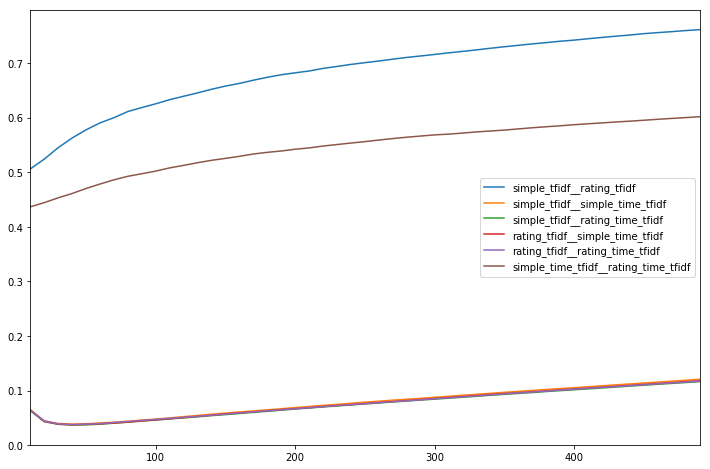

In [84]:
jaccard_part_2 = draw_jaccard(r_across_variants__part_2, vr_list__part_2)

In [93]:
jaccard_part_2['rating_tfidf__simple_time_tfidf']

[0.064720625092142117,
 0.043882333996111085,
 0.038785900403180404,
 0.037567170678544815,
 0.038197984527383322,
 0.039458283069749425,
 0.040667362499426048,
 0.042638064707307383,
 0.044592840309028159,
 0.046596055841810063,
 0.048582424307309593,
 0.0506735341273091,
 0.053001576985301661,
 0.055119771328206085,
 0.057334837508387158,
 0.05934828586978623,
 0.061214591869560048,
 0.063323456744844728,
 0.065334347465828571,
 0.067134015677497091,
 0.068946834625860098,
 0.070897452573594505,
 0.07284938920320827,
 0.074614175333598667,
 0.076562683448122712,
 0.078380005494660787,
 0.08012823626027947,
 0.081926380044874389,
 0.083780712475245753,
 0.08564214624027798,
 0.087536850368391234,
 0.089297729608644835,
 0.091132449966436949,
 0.093034496046056001,
 0.094693322638827918,
 0.09634861087387056,
 0.097950957948902392,
 0.099713922691392259,
 0.10148786449896485,
 0.10308200238090066,
 0.10487038618039955,
 0.10653785649429637,
 0.10815040629135955,
 0.10984979008545998,
 